# Trait Cosine Similarity with Contrast Vector

In [1]:
import os
import sys
import torch
import numpy as np
import torch.nn.functional as F

sys.path.append('.')
sys.path.append('..')

import matplotlib.pyplot as plt
plt.style.use('./arena.mplstyle')

In [42]:
# Config
plot_output_dir = "/root/git/plots/paper"
model_short = "qwen-3-32b"
layer = 32
dir = f"/workspace/{model_short}"

In [43]:
# Load trait PCA results
trait_results = torch.load(f"{dir}/traits_240/pca/layer{layer}_pos-neg50.pt", weights_only=False)
trait_names = trait_results['traits']['pos_neg_50']

# Load contrast vector
contrast_vector = torch.load(f"{dir}/roles_240/contrast_vectors.pt", weights_only=False)[layer]
contrast_vector = F.normalize(contrast_vector, dim=0).float() * -1

/root/git/persona-subspace/.venv/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/root/git/persona-subspace/.venv/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [44]:
# Get trait vectors at layer and normalize
trait_tensor = torch.stack(trait_results['vectors']['pos_neg_50'])
trait_layer_vectors = trait_tensor[:, layer].float()

normalized_trait_vectors = F.normalize(trait_layer_vectors, dim=1)


# Compute cosine similarities
trait_cosine_sims = (normalized_trait_vectors @ contrast_vector).numpy()
print(f"Trait cosine sims shape: {trait_cosine_sims.shape}")
print(f"Range: [{trait_cosine_sims.min():.3f}, {trait_cosine_sims.max():.3f}]")

Trait cosine sims shape: (240,)
Range: [-0.830, 0.571]


In [45]:
# Print top 20 traits at each end
sorted_indices = np.argsort(trait_cosine_sims)

print("=== Top 20 NEGATIVE (Role-playing) ===")
for i, idx in enumerate(sorted_indices[:20]):
    print(f"{i+1:2d}. {trait_names[idx]:20s} {trait_cosine_sims[idx]:.3f}")

print("\n=== Top 20 POSITIVE (Assistant-like) ===")
for i, idx in enumerate(sorted_indices[-20:][::-1]):
    print(f"{i+1:2d}. {trait_names[idx]:20s} {trait_cosine_sims[idx]:.3f}")

=== Top 20 NEGATIVE (Role-playing) ===
 1. rhetorical           -0.830
 2. grandiose            -0.815
 3. dramatic             -0.804
 4. metaphorical         -0.802
 5. enigmatic            -0.800
 6. paradoxical          -0.797
 7. narrative            -0.787
 8. theatrical           -0.778
 9. obsessive            -0.777
10. cryptic              -0.766
11. melodramatic         -0.764
12. creative             -0.755
13. romantic             -0.726
14. ethereal             -0.719
15. poetic               -0.710
16. risk_taking          -0.698
17. zealous              -0.696
18. spontaneous          -0.695
19. subversive           -0.684
20. artistic             -0.683

=== Top 20 POSITIVE (Assistant-like) ===
 1. moderate             0.571
 2. conciliatory         0.560
 3. reserved             0.556
 4. calm                 0.555
 5. grounded             0.548
 6. diplomatic           0.532
 7. dispassionate        0.511
 8. factual              0.504
 9. descriptive          0.491


In [46]:
contrast_vector_nosys = torch.load(f"{dir}/roles_240/contrast_vectors_nosys.pt", weights_only=False)[layer]
contrast_vector_nosys = F.normalize(contrast_vector_nosys, dim=0).float() * -1

# Compute cosine similarities
trait_cosine_sims_nosys = (normalized_trait_vectors @ contrast_vector_nosys).numpy()
print(f"Trait cosine sims shape: {trait_cosine_sims_nosys.shape}")
print(f"Range: [{trait_cosine_sims_nosys.min():.3f}, {trait_cosine_sims_nosys.max():.3f}]")

# Print top 20 traits at each end
sorted_indices_nosys = np.argsort(trait_cosine_sims_nosys)

print("=== Top 20 NEGATIVE (Role-playing) ===")
for i, idx in enumerate(sorted_indices_nosys[:20]):
    print(f"{i+1:2d}. {trait_names[idx]:20s} {trait_cosine_sims_nosys[idx]:.3f}")

print("\n=== Top 20 POSITIVE (Assistant-like) ===")
for i, idx in enumerate(sorted_indices_nosys[-20:][::-1]):
    print(f"{i+1:2d}. {trait_names[idx]:20s} {trait_cosine_sims_nosys[idx]:.3f}")

Trait cosine sims shape: (240,)
Range: [-0.797, 0.623]
=== Top 20 NEGATIVE (Role-playing) ===
 1. enigmatic            -0.797
 2. narrative            -0.771
 3. romantic             -0.764
 4. rhetorical           -0.763
 5. metaphorical         -0.754
 6. paradoxical          -0.753
 7. dramatic             -0.752
 8. spontaneous          -0.746
 9. ethereal             -0.738
10. grandiose            -0.733
11. cryptic              -0.729
12. obsessive            -0.728
13. improvisational      -0.725
14. melodramatic         -0.716
15. theatrical           -0.703
16. mystical             -0.703
17. artistic             -0.694
18. mercurial            -0.683
19. poetic               -0.678
20. zealous              -0.676

=== Top 20 POSITIVE (Assistant-like) ===
 1. reserved             0.623
 2. methodical           0.606
 3. calm                 0.592
 4. dispassionate        0.588
 5. factual              0.574
 6. moderate             0.562
 7. rationalist          0.558
 8. dip

In [47]:
from matplotlib.colors import LinearSegmentedColormap

def plot_trait_line(cosine_sims, trait_names, include_labels=None, exclude_labels=None,
                    figsize=(8, 3), n_extremes=5, show_histogram=True):
    """
    Plot trait cosine similarities on a line.

    Args:
        cosine_sims: (n_traits,) array of cosine similarities
        trait_names: List of trait names
        include_labels: List of trait names to always label (optional)
        exclude_labels: List of trait names to exclude from labeling (optional)
        figsize: Figure size tuple
        n_extremes: Number of extremes to label on each end
        show_histogram: Whether to show histogram overlay
    """
    include_labels = include_labels or []
    exclude_labels = exclude_labels or []
    
    projections = cosine_sims
    
    # Build index sets for include/exclude
    trait_to_idx = {name: i for i, name in enumerate(trait_names)}
    include_idx = set(trait_to_idx[t] for t in include_labels if t in trait_to_idx)
    exclude_idx = set(trait_to_idx[t] for t in exclude_labels if t in trait_to_idx)
    
    # Find extreme indices - just the n_extremes at each end
    sorted_indices = np.argsort(projections)
    low_extreme_indices = list(sorted_indices[:n_extremes])
    high_extreme_indices = list(sorted_indices[-n_extremes:])
    extreme_indices = set(low_extreme_indices + high_extreme_indices)
    
    # Indices to label = extremes + include, minus exclude
    indices_to_label = (extreme_indices | include_idx) - exclude_idx
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Create gradient colormap: red (#e63946) to blue (#457b9d)
    custom_cmap = LinearSegmentedColormap.from_list('RedBlue1', ['#e63946', '#457b9d'])
    
    # Normalize projections for coloring (map to 0-1 range)
    proj_norm = (projections - projections.min()) / (projections.max() - projections.min())
    colors = custom_cmap(proj_norm)
    
    # Plot all points with gradient colors
    y_pos = np.zeros_like(projections)
    ax.scatter(projections, y_pos, c=colors, marker='D', s=40, 
               alpha=0.6, edgecolors='none', zorder=3)
    
    # Add histogram overlay
    if show_histogram:
        hist_counts, bin_edges = np.histogram(projections, bins=30, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bin_width = bin_edges[1] - bin_edges[0]
        
        hist_scale = 0.4
        scaled_heights = hist_counts * hist_scale
        
        # Color histogram bars with gradient
        bin_norm = (bin_centers - projections.min()) / (projections.max() - projections.min())
        bin_colors = custom_cmap(bin_norm)
        
        ax.bar(bin_centers, scaled_heights, width=bin_width, 
               alpha=0.3, color=bin_colors, edgecolor='none', zorder=1)
    
    # Fixed y positions with same spacing above and below
    y_above = [0.15, 0.25, 0.35]
    y_below = [-0.15, -0.25, -0.35]
    
    # Separate low and high indices from indices_to_label
    low_to_label = [idx for idx in low_extreme_indices if idx in indices_to_label]
    high_to_label = [idx for idx in reversed(high_extreme_indices) if idx in indices_to_label]
    
    # Add labels for low extremes (left side) - alternate above/below
    for i, idx in enumerate(low_to_label):
        label = trait_names[idx].replace('_', ' ').title()
        x_pos = projections[idx]
        
        if i % 2 == 0:  # above
            y_label = y_above[i // 2] if i // 2 < len(y_above) else y_above[-1]
            va = 'bottom'
            line_end = y_label - 0.02
        else:  # below
            y_label = y_below[i // 2] if i // 2 < len(y_below) else y_below[-1]
            va = 'top'
            line_end = y_label + 0.02
        
        # Draw leader line
        ax.plot([x_pos, x_pos], [0.02 if y_label > 0 else -0.02, line_end], '-', color='gray', 
                alpha=0.4, linewidth=0.8, zorder=1)
        
        ax.text(x_pos, y_label, label, ha='center', va=va, fontsize=9, zorder=4)
    
    # Add labels for high extremes (right side) - alternate above/below
    for i, idx in enumerate(high_to_label):
        label = trait_names[idx].replace('_', ' ').title()
        x_pos = projections[idx]
        
        if i % 2 == 0:  # above
            y_label = y_above[i // 2] if i // 2 < len(y_above) else y_above[-1]
            va = 'bottom'
            line_end = y_label - 0.02
        else:  # below
            y_label = y_below[i // 2] if i // 2 < len(y_below) else y_below[-1]
            va = 'top'
            line_end = y_label + 0.02
        
        # Draw leader line  
        ax.plot([x_pos, x_pos], [0.02 if y_label > 0 else -0.02, line_end], '-', color='gray', 
                alpha=0.4, linewidth=0.8, zorder=1)
        
        ax.text(x_pos, y_label, label, ha='center', va=va, fontsize=9, zorder=4)
    
    # Add directional annotations
    max_abs = max(abs(projections.min()), abs(projections.max()))
    
    # Left side: Role-playing traits (red arrow pointing left)
    left_x = -max_abs 
    ax.annotate('Role-playing', xy=(left_x, -0.45), xytext=(left_x + max_abs * 0.25, -0.45),
                arrowprops=dict(arrowstyle='->', color='#e63946', lw=2),
                fontsize=12, fontweight='bold', color='#e63946', ha='left', va='center')
    
    # Right side: Assistant-like traits (blue arrow pointing right)
    right_x = max_abs 
    ax.annotate('Assistant-like', xy=(right_x, -0.45), xytext=(right_x - max_abs * 0.25, -0.45),
                arrowprops=dict(arrowstyle='->', color='#457b9d', lw=2),
                fontsize=12, fontweight='bold', color='#457b9d', ha='right', va='center')
    
    # Style
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=2, zorder=1)
    
    ax.tick_params(axis='x', length=12, width=1.5, pad=10)
    ax.tick_params(axis='y', length=0, width=0)
    ax.set_yticks([])
    ax.set_xticks([-0.8, -0.4, 0, 0.4, 0.8])
    ax.set_ylim(-0.55, 0.5)
    
    ax.set_xlim(-1, 1)
    
    ax.grid(False)

    plt.tight_layout()
    return fig

In [48]:
from matplotlib.colors import LinearSegmentedColormap

def plot_trait_comparison(cosine_sims_sys, cosine_sims_nosys, trait_names,
                          figsize=(10, 6), n_extremes=5, show_histogram=True,
                          model_name=None):
    """
    Plot trait cosine similarities comparison: with vs without system prompt.
    
    Args:
        cosine_sims_sys: (n_traits,) array of cosine similarities WITH system prompt
        cosine_sims_nosys: (n_traits,) array of cosine similarities WITHOUT system prompt
        trait_names: List of trait names
        figsize: Figure size tuple
        n_extremes: Number of extremes to label on each end (default 5)
        show_histogram: Whether to show histogram overlay
        model_name: Optional model name for title
    """
    # Create figure with 2 rows
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)
    
    # Add model name as title
    if model_name:
        fig.suptitle(model_name, fontsize=14, fontweight='bold', y=0.98)
    
    # Create gradient colormap: red (#e63946) to blue (#457b9d)
    custom_cmap = LinearSegmentedColormap.from_list('RedBlue1', ['#e63946', '#457b9d'])
    
    datasets = [
        (cosine_sims_sys, "With System Prompt", axes[0]),
        (cosine_sims_nosys, "Without System Prompt", axes[1]),
    ]
    
    for projections, subtitle, ax in datasets:
        # Find extreme indices - just the n_extremes at each end
        sorted_indices = np.argsort(projections)
        low_extreme_indices = list(sorted_indices[:n_extremes])
        high_extreme_indices = list(sorted_indices[-n_extremes:])
        
        # Normalize projections for coloring
        proj_norm = (projections - projections.min()) / (projections.max() - projections.min())
        colors = custom_cmap(proj_norm)
        
        # Plot all points
        y_pos = np.zeros_like(projections)
        ax.scatter(projections, y_pos, c=colors, marker='D', s=40, 
                   alpha=0.6, edgecolors='none', zorder=3)
        
        # Add histogram overlay
        if show_histogram:
            hist_counts, bin_edges = np.histogram(projections, bins=30, density=True)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            bin_width = bin_edges[1] - bin_edges[0]
            
            hist_scale = 0.35
            scaled_heights = hist_counts * hist_scale
            
            bin_norm = (bin_centers - projections.min()) / (projections.max() - projections.min())
            bin_colors = custom_cmap(bin_norm)
            
            ax.bar(bin_centers, scaled_heights, width=bin_width, 
                   alpha=0.3, color=bin_colors, edgecolor='none', zorder=1)
        
        # Fixed y positions with same spacing above and below
        y_above = [0.15, 0.25, 0.35]
        y_below = [-0.15, -0.25, -0.35]
        
        # Add labels for low extremes (left side) - alternate above/below
        for i, idx in enumerate(low_extreme_indices):
            label = trait_names[idx].replace('_', ' ').title()
            x_pos = projections[idx]
            
            if i % 2 == 0:  # above
                y_label = y_above[i // 2]
                va = 'bottom'
                line_end = y_label - 0.02
            else:  # below
                y_label = y_below[i // 2]
                va = 'top'
                line_end = y_label + 0.02
            
            # Draw leader line
            ax.plot([x_pos, x_pos], [0.02 if y_label > 0 else -0.02, line_end], '-', color='gray', 
                    alpha=0.4, linewidth=0.8, zorder=1)
            
            ax.text(x_pos, y_label, label, ha='center', va=va, fontsize=8, zorder=4)
        
        # Add labels for high extremes (right side) - alternate above/below
        for i, idx in enumerate(reversed(high_extreme_indices)):
            label = trait_names[idx].replace('_', ' ').title()
            x_pos = projections[idx]
            
            if i % 2 == 0:  # above
                y_label = y_above[i // 2]
                va = 'bottom'
                line_end = y_label - 0.02
            else:  # below
                y_label = y_below[i // 2]
                va = 'top'
                line_end = y_label + 0.02
            
            # Draw leader line  
            ax.plot([x_pos, x_pos], [0.02 if y_label > 0 else -0.02, line_end], '-', color='gray', 
                    alpha=0.4, linewidth=0.8, zorder=1)
            
            ax.text(x_pos, y_label, label, ha='center', va=va, fontsize=8, zorder=4)
        
        # Add subtitle - higher up with more space below
        ax.text(-0.95, 0.52, subtitle, fontsize=11, fontweight='bold', 
                ha='left', va='top', color='#333333')
        
        # Style
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_position('zero')
        ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5, zorder=1)
        
        ax.tick_params(axis='x', length=8, width=1, pad=8)
        ax.tick_params(axis='y', length=0, width=0)
        ax.set_yticks([])
        ax.set_ylim(-0.45, 0.55)
        ax.set_xlim(-1, 1)
        ax.grid(False)
    
    # Add x-axis ticks only on bottom subplot
    axes[1].set_xticks([-0.8, -0.4, 0, 0.4, 0.8])
    axes[0].tick_params(axis='x', length=0)
    
    # Add directional annotations on bottom subplot only - lower position
    max_abs = 0.9
    axes[1].annotate('Role-playing', xy=(-max_abs, -0.38), xytext=(-max_abs + 0.25, -0.38),
                arrowprops=dict(arrowstyle='->', color='#e63946', lw=2),
                fontsize=11, fontweight='bold', color='#e63946', ha='left', va='center')
    
    axes[1].annotate('Assistant-like', xy=(max_abs, -0.38), xytext=(max_abs - 0.25, -0.38),
                arrowprops=dict(arrowstyle='->', color='#457b9d', lw=2),
                fontsize=11, fontweight='bold', color='#457b9d', ha='right', va='center')
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, top=0.93 if model_name else 0.95)
    return fig

In [52]:
# Label configuration - adjust these lists as needed
trait_config = {
    'include_labels': [],  # traits to always label
    'exclude_labels': [],  # traits to never label
}

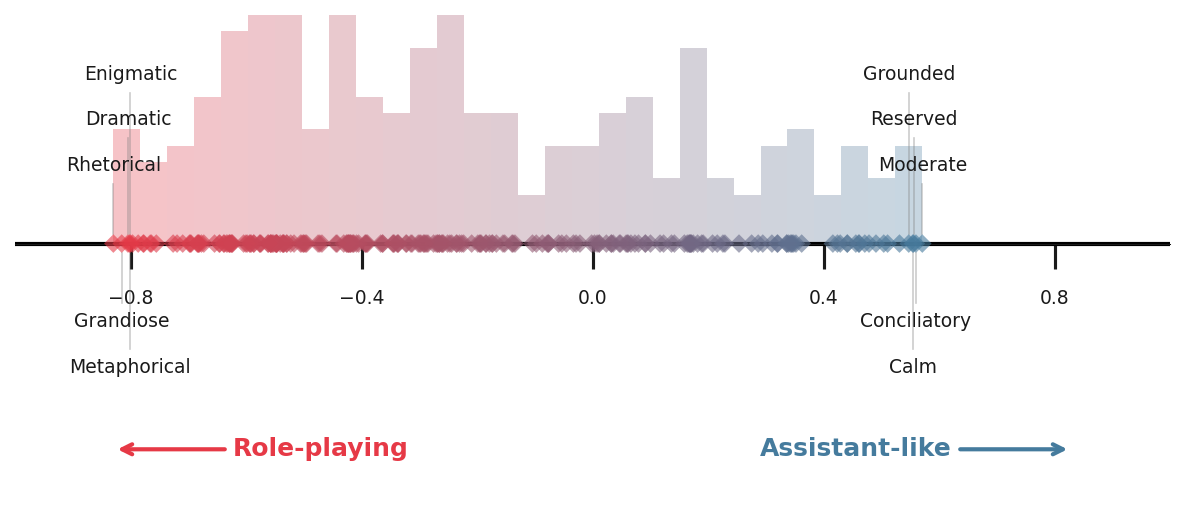

In [55]:
# Generate plot
fig = plot_trait_line(
    trait_cosine_sims, trait_names,
    include_labels=trait_config['include_labels'],
    exclude_labels=trait_config['exclude_labels'],
    n_extremes=5,
    show_histogram=True, figsize=(8, 3.5)
)
plt.savefig(f"{plot_output_dir}/trait_contrast_line.pdf", dpi=300, bbox_inches='tight')
plt.show()

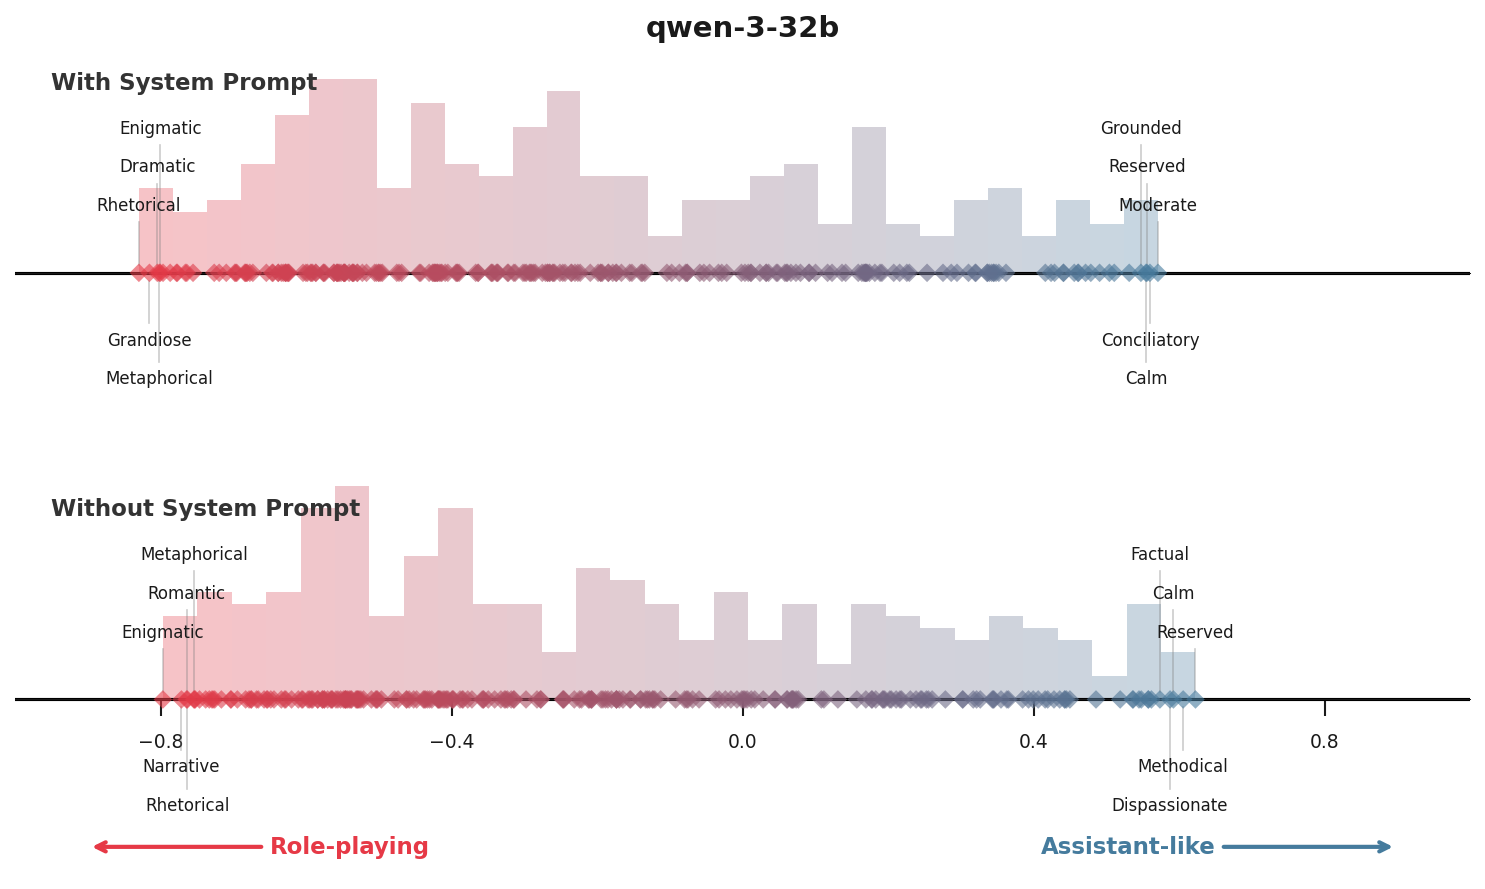

In [51]:
# Generate comparison plot (with vs without system prompt)
fig = plot_trait_comparison(
    trait_cosine_sims, 
    trait_cosine_sims_nosys, 
    trait_names,
    figsize=(10, 6),
    n_extremes=5,
    show_histogram=True,
    model_name=model_short,
)
plt.savefig(f"{plot_output_dir}/trait_contrast_comparison.pdf", dpi=300, bbox_inches='tight')
plt.show()